In [1]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from pandas import read_csv
from utils import *

In [2]:
def printRelevant(strike, stock, DTE, volatility=None, r=None):
    if volatility is not None and r is not None:
        value = BlackScholes(strike, stock, DTE, volatility=volatility, r=r)
    elif volatility is not None:
        value = BlackScholes(strike, stock, DTE, volatility=volatility)
    elif r is not None:
        value = BlackScholes(strike, stock, DTE, r=r)
    else:
        value = BlackScholes(strike, stock, DTE)
    theta = Greeks(strike, stock, DTE, greek="theta")
    delta = Greeks(strike, stock, DTE, greek="delta")
    gamma = Greeks(strike, stock, DTE, greek="gamma")

    leverage = stock*delta/value
    decay = 100 * theta / value
    nonlinearity = 5e-5 * gamma*stock**2/value
    
    print("Contract value = $%.2f" % value)
    print("Decay Rate = %.2f%%" % decay)
    print("Leverage = %.3f" % leverage)
    print("Nonlinearity = %.3f" % nonlinearity)
    
def calcPercentReturn(myCash):
    time = len(myCash) * deltaT
    factor = (myCash[-1] / myCash[0])**(365 / time)
    return 100*(factor-1)

def calcFinalReturn(myCash):
    dollar = int(round(myCash[-1]))
    return format(dollar, ",")

# stock = 349.36
# strike = 345
# DTE = 462
# printRelevant(strike, stock, DTE, volatility=0.2057, r = 0.0074)

In [3]:
### Loading Data...

data = read_csv("data/SPY.csv")
vix = read_csv("data/VIX.csv")
dates = np.array(data["Date"], dtype = str)

### Loading risk free interest rate
TresYield = read_csv("data/USTREASURY-YIELD.csv")
TresDates = np.array(TresYield["Date"][::-1], dtype = str)
TresRate = np.array(TresYield["1 YR"][::-1])
r = np.zeros(len(dates))
i = j = 0
while i < len(dates):
    r[i] = TresRate[j]/100
    if dates[i] == TresDates[j]:
        i += 1
        j += 1
    elif dates[i] < TresDates[j]:
        i += 1
    elif dates[i] > TresDates[j]:
        j += 1
###

deltaT = 365/252

yearStart = 1994
#yearStart = 2009.2
yearEnd = 2021

idxStart = int(252*(yearStart - 1994))
idxEnd = int(252*(yearEnd - 1994))

prices = np.array(data["Close"])[idxStart:idxEnd]
volatility = np.array(vix["Close"])[idxStart:idxEnd]/100
volatilityLEAP = 0.807*volatility
volatilityCC = 0.693*volatility
n = len(prices)
times = np.arange(n)
deltaT = 365/252

date = times/252 + yearStart

In [4]:
### Strategy 1: Buy and Hold

myCashSPY = np.zeros(n)
myCashSPY[0] = 1000

SPY = prices[0]
nShares = myCashSPY[0] / SPY 
for i in range(1, n):
    SPY = prices[i]
    myCashSPY[i] = nShares * SPY
    
percentReturnSPY = calcPercentReturn(myCashSPY)
dollarReturnSPY = calcFinalReturn(myCashSPY)

print("Investing in $1,000 of S&P 500 stock in %d:" % yearStart)
print("Present value = $%s for an average annual return of %.1f%%" % (dollarReturnSPY, percentReturnSPY))

Investing in $1,000 of S&P 500 stock in 1994:
Present value = $7,389 for an average annual return of 7.8%


In [5]:
### Strategy 2: Covered Calls

enterCC = 30
exitCC = deltaT
deltaCC = 0.15

myCashCC = np.zeros(n)
myCashCC[0] = 1000

SPY = prices[0]
nShares = myCashCC[0] / SPY 

strikeCC = findStrike(deltaCC, SPY, enterCC, volatilityCC[0], r[0])
CC = BlackScholes(strikeCC, SPY, enterCC, volatilityCC[0], r[0])
daysSinceOpenCC = 0

for i in range(1, n):
    daysSinceOpenCC += deltaT
    SPY = prices[i]
    
    CCValue = BlackScholes(strikeCC, SPY, enterCC - daysSinceOpenCC, volatilityCC[i], r[i])
    myCashCC[i] = nShares * (SPY + CC - CCValue)
    
    if (enterCC - daysSinceOpenCC) <= exitCC:
        myCashCC[i] = nShares * (SPY + CC - CCValue - 0.013)   # $1.30 contract fee
        nShares = myCashCC[i] / SPY 
        
        strikeCC = findStrike(deltaCC, SPY, enterCC, volatilityCC[i], r[i])
        CC = BlackScholes(strikeCC, SPY, enterCC, volatilityCC[i], r[i])
        daysSinceOpenCC = 0
        
percentReturnCC = calcPercentReturn(myCashCC)
dollarReturnCC = calcFinalReturn(myCashCC)

print("Investing in $1,000 of S&P 500 stock + covered calls %d:" % yearStart)
print("Present value = $%s for an average annual return of %.1f%%" % (dollarReturnCC, percentReturnCC))

Investing in $1,000 of S&P 500 stock + covered calls 1994:
Present value = $8,100 for an average annual return of 8.1%


In [6]:
### Strategy 3: LEAPs
enterLEAP = 800
exitLEAP = enterLEAP - 365
deltaLEAP = 0.8

myCashLEAP = np.zeros(n)
myCashLEAP[0] = 1000

SPY = prices[0]
strikeLEAP = findStrike(deltaLEAP, SPY, enterLEAP, volatilityLEAP[0], r[0])
LEAP = BlackScholes(strikeLEAP, SPY, enterLEAP, volatilityLEAP[0], r[0])

nContracts = myCashLEAP[0] / LEAP
daysSinceOpenLEAP = 0

for i in range(1, n):
    daysSinceOpenLEAP += deltaT
    SPY = prices[i]
    
    LeapValue = BlackScholes(strikeLEAP, SPY, enterLEAP-daysSinceOpenLEAP, volatilityLEAP[i], r[i])
    myCashLEAP[i] = nContracts * LeapValue
    
    if (enterLEAP - daysSinceOpenLEAP) <= exitLEAP:
        strikeLEAP = findStrike(deltaLEAP, SPY, enterLEAP, volatilityLEAP[i], r[i])
        LEAP = BlackScholes(strikeLEAP, SPY, enterLEAP, volatilityLEAP[i], r[i])
        nContracts = myCashLEAP[i] / (1.03*LEAP)   # 3% loss on bid-ask
        daysSinceOpenLEAP = 0
        
percentReturnLEAP = calcPercentReturn(myCashLEAP)
dollarReturnLEAP = calcFinalReturn(myCashLEAP)

print("Investing in $1,000 of S&P 500 LEAPS %d:" % yearStart)
print("Present value = $%s for an average annual return of %.1f%%" % (dollarReturnLEAP, percentReturnLEAP))

Investing in $1,000 of S&P 500 LEAPS 1994:
Present value = $25,647 for an average annual return of 12.9%


In [7]:
### Strategy 4: Poor Man's Covered Calls

enterLEAP = 800
exitLEAP = enterLEAP - 365
deltaLEAP = 0.8

enterCC = 30
exitCC = deltaT
deltaCC = 0.15

myCashPMCC = np.zeros(n)
myCashPMCC[0] = 1000

SPY = prices[0]
strikeLEAP = findStrike(deltaLEAP, SPY, enterLEAP, volatilityLEAP[0], r[0])
LEAP = BlackScholes(strikeLEAP, SPY, enterLEAP, volatilityLEAP[0], r[0])

nContracts = myCashPMCC[0] / LEAP
daysSinceOpenLEAP = 0

strikeCC = findStrike(deltaCC, SPY, enterCC, volatilityCC[0], r[0])
CC = BlackScholes(strikeCC, SPY, enterCC, volatilityCC[0], r[0])
daysSinceOpenCC = 0

positive = []
negative = []

for i in range(1, n):
    daysSinceOpenLEAP += deltaT
    daysSinceOpenCC += deltaT
    SPY = prices[i]
        
    LeapValue = BlackScholes(strikeLEAP, SPY, enterLEAP-daysSinceOpenLEAP, volatilityLEAP[i], r[i])
    CCValue = BlackScholes(strikeCC, SPY, enterCC - daysSinceOpenCC, volatilityCC[i], r[i])
    myCashPMCC[i] = nContracts * (LeapValue + CC - CCValue)
    
    if (enterCC - daysSinceOpenCC) <= exitCC:       
        myCashPMCC[i] = nContracts * (LeapValue + CC - CCValue - 0.013) # $1.30 contract fee
        nContracts = myCashPMCC[i] / LeapValue 

        strikeCC = findStrike(deltaCC, SPY, enterCC, volatilityCC[i], r[i])
        CC = BlackScholes(strikeCC, SPY, enterCC, volatilityCC[i], r[i])
        daysSinceOpenCC = 0
        
    if (enterLEAP - daysSinceOpenLEAP) <= exitLEAP:
        strikeLEAP = findStrike(deltaLEAP, SPY, enterLEAP, volatilityLEAP[i], r[i])
        LEAP = BlackScholes(strikeLEAP, SPY, enterLEAP, volatilityLEAP[i], r[i])
        nContracts = myCashPMCC[i] / (1.03*LEAP)   # 3% loss on bid-ask
        daysSinceOpenLEAP = 0
        
percentReturnPMCC = calcPercentReturn(myCashPMCC)
dollarReturnPMCC = calcFinalReturn(myCashPMCC)

print("Investing in $1,000 of S&P 500 LEAPS + covered calls %d:" % yearStart)
print("Present value = $%s for an average annual return of %.1f%%" % (dollarReturnPMCC, percentReturnPMCC))

Investing in $1,000 of S&P 500 LEAPS + covered calls 1994:
Present value = $84,023 for an average annual return of 18.0%


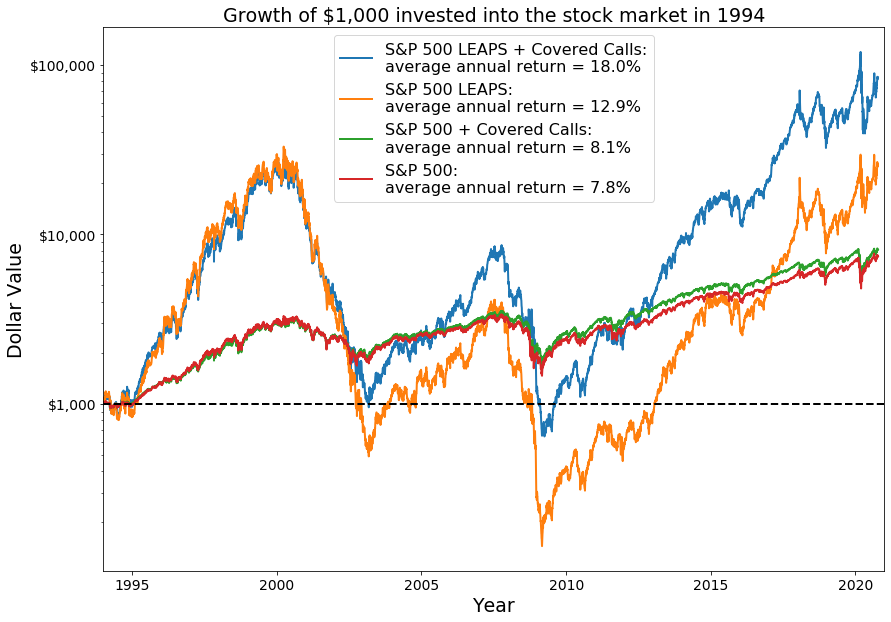

In [8]:
fig, ax = plt.subplots(figsize = [14, 10])
plt.plot(date, myCashPMCC, linewidth=2, label = "S&P 500 LEAPS + Covered Calls:\naverage annual return = %.1f%%" % percentReturnPMCC)
plt.plot(date, myCashLEAP, linewidth=2, label = "S&P 500 LEAPS:\naverage annual return = %.1f%%" % percentReturnLEAP)
plt.plot(date, myCashCC, linewidth=2, label = "S&P 500 + Covered Calls:\naverage annual return = %.1f%%" % percentReturnCC)
plt.plot(date, myCashSPY, linewidth=2, label="S&P 500:\naverage annual return = %.1f%%" % percentReturnSPY)
plt.legend(fontsize = 16)
plt.title("Growth of $1,000 invested into the stock market in %d" % yearStart, fontsize = 19)
plt.semilogy()
plt.axhline(y=1000, color = 'k', linestyle = 'dashed', linewidth=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Dollar Value", fontsize=19)
tick = ticker.StrMethodFormatter("${x:,.0f}")
#plt.ylim(1e2, 1e6)
plt.xlim(yearStart, yearEnd)
ax.yaxis.set_major_formatter(tick)
plt.savefig("Long")